In [ ]:
import numpy as np, torch, json, time, os
from Ctubes.geometry_utils import compute_cross_section_radii
from Ctubes.plot_utils import plot_generatrix
from Ctubes.tubes import Directrix, Generatrix, CTube
from Ctubes.target_cross_sections import fix_end_cross_sections
from Ctubes.opt import CTubeOptimizationProblem
from Ctubes.misc_utils import load_curve_from_obj
from Ctubes.path_utils import get_name, setup_paths

paths = setup_paths(get_name())

PI = np.pi
TORCH_DTYPE = torch.float64
torch.set_default_dtype(TORCH_DTYPE)
torch.set_printoptions(precision=4)

%load_ext autoreload
%autoreload 2

%matplotlib widget

# Figure 11: Cross-Section Scaling with Planar Quads

In [3]:
# Define a path to output specific to the current test case
paths = setup_paths(get_name(), test_name="fig11_scaling_optimized")

In [5]:
# Directrix: read curve from file
cps_ref = load_curve_from_obj(os.path.join(paths["data"], "fig11_scaling/directrix_Q.obj"))
K = cps_ref.shape[0]
M = 2*K

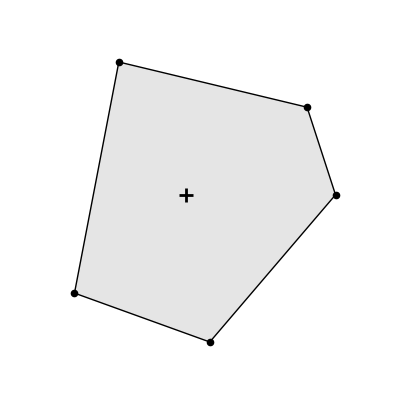

In [6]:
# Generatrix: custom pentagon
N = 5
tube_radius = 0.3
generatrix_2d = torch.zeros(size=(N, 2))
generatrix_2d[:, 0] = tube_radius * torch.cos(torch.linspace(0.0, 2.0 * PI, N+1)[:-1])
generatrix_2d[:, 1] = tube_radius * torch.sin(torch.linspace(0.0, 2.0 * PI, N+1)[:-1])

# Move vertices on circle
displacement = tube_radius
generatrix_2d[1] += torch.tensor([displacement, 0])
generatrix_2d[2] += torch.tensor([0, displacement])
generatrix_2d[3] += torch.tensor([-displacement, -displacement])
generatrix_2d[4] += torch.tensor([0, -displacement])
for i in range(N):
    generatrix_2d[i] = tube_radius * generatrix_2d[i] / torch.linalg.norm(generatrix_2d[i]) # project back on circle

fig, ax = plot_generatrix(generatrix_2d)

In [7]:
# C-tube
directrix = Directrix(cps_ref, M)

X0 = directrix.X[0]
T0 = directrix.get_tangents()[0]
theta = torch.tensor(PI/2)
generatrix = Generatrix(generatrix_2d, X0, T0, theta)

tube = CTube(directrix, generatrix)

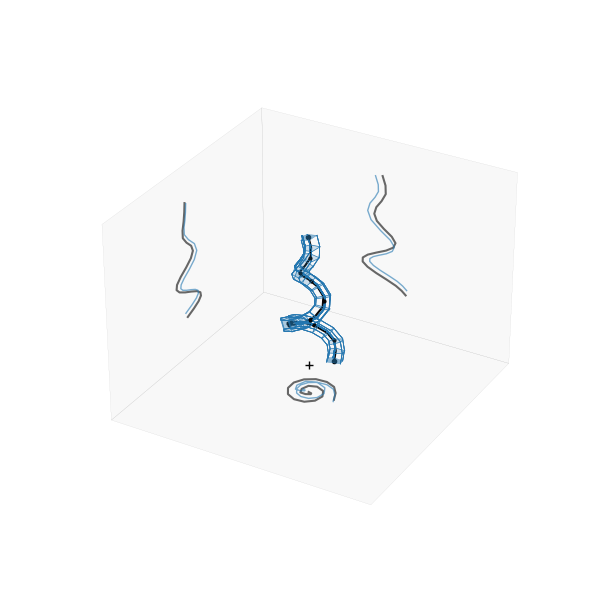

In [8]:
fig, ax = tube.plot_3d()

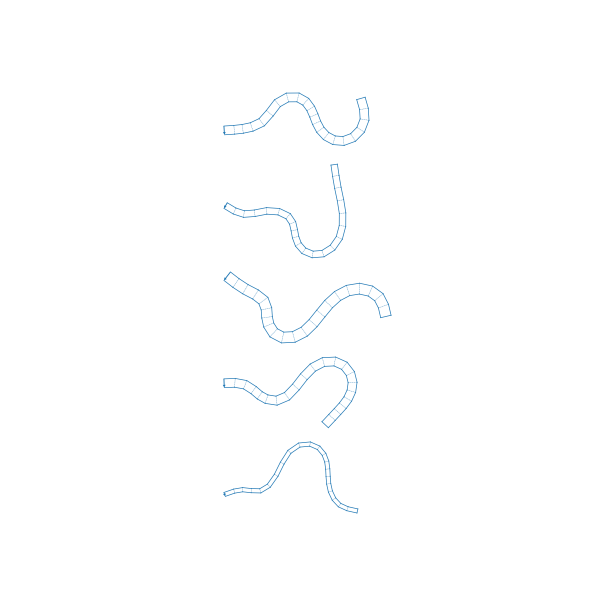

In [9]:
fig, ax = tube.plot_unrolled_strips()

### Manual Cross-Section Scaling $\implies$ Non-PQ Mesh

In [ ]:
# Measure initial planarity of the quads
import meshplot as mp
from Ctubes.tube_generation import compute_ctube_topology, compute_ctube_topology_tri
from Ctubes.geometry_utils import compute_quad_nonplanarity

ctube_vertices = tube.compute_vertices()
ctube_vertices_plot = ctube_vertices.clone()

V = ctube_vertices_plot.reshape(-1, 3)
F, F_caps = compute_ctube_topology_tri(M, N)

scalar_field = compute_quad_nonplanarity(ctube_vertices_plot).numpy()
scalar_field = np.repeat(scalar_field, 2, axis=0).flatten()
print("Min nonplanarity:", scalar_field.min())
print("Max nonplanarity:", scalar_field.max())

# Modify one of the values to have full blue mesh if range is small
scalar_field[0] = 1.0

try:
    mesh_plt = mp.plot(V.numpy(), F.numpy(), scalar_field, shading={"wireframe": True, "flat": False})
except NameError:
    pass  # Ignore meshplot display errors in script mode

Min nonplanarity: 0.0
Max nonplanarity: 1.9615904926503648e-16


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.1259375…

In [ ]:
# Apply sinusoidal scaling along the cross-sections of the tube
ctube_vertices = tube.compute_vertices()
ctube_vertices_manual = ctube_vertices.clone()
directrix = tube.get_polyline()
scaling_factors = 1.0 - 0.4 * torch.sin(2*PI*torch.linspace(0, 1, M))
for i in range(M):
    centroid = torch.mean(ctube_vertices[i], dim=0)
    ctube_vertices_manual[i] = centroid + scaling_factors[i] * (ctube_vertices[i] - centroid)

In [ ]:
# Measure planarity of the quads after scaling
import meshplot as mp
from Ctubes.tube_generation import compute_ctube_topology, compute_ctube_topology_tri

ctube_vertices_plot = ctube_vertices_manual.clone()

V = ctube_vertices_plot.reshape(-1, 3)
F, F_caps = compute_ctube_topology_tri(M, N)

scalar_field = compute_quad_nonplanarity(ctube_vertices_plot).numpy()
scalar_field = np.repeat(scalar_field, 2, axis=0).flatten()
print("Min nonplanarity:", scalar_field.min())
print("Max nonplanarity:", scalar_field.max())

# Generate colormap
import matplotlib.pyplot as plt
scalar_field_normalized = (scalar_field - scalar_field.min()) / (scalar_field.max() - scalar_field.min())  # Normalize the scalar field to the range [0, 1]
cmap = plt.get_cmap('Reds')  # Create a colormap that maps low values to white and high values to red
scalar_field_rgb = cmap(scalar_field_normalized)[:, :3]  # # Convert the normalized scalar field to RGB values using the colormap, Ignore the alpha channel

try:
    mesh_plt = mp.plot(V.numpy(), F.numpy(), scalar_field_rgb, shading={"wireframe": True, "flat": False})
except NameError:
    pass  # Ignore meshplot display errors in script mode

Min nonplanarity: 9.054004885893643e-06
Max nonplanarity: 0.005779236267017745


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0644143…

In [ ]:
# Save the mesh to file
from Ctubes.misc_utils import write_mesh_to_obj
paths_manual = setup_paths(get_name(), test_name="fig11_scaling_manual")

V = V.numpy()
F = F.numpy()
save_path = os.path.join(paths_manual["output_meshes"], "{}_3d_tube.obj".format(paths_manual["name"]))
write_mesh_to_obj(save_path, V, F)

True

In [14]:
# Save to json
save_path = os.path.join(paths_manual["output_meshes"], "{}_3d_tube.json".format(paths_manual["name"]))

with open(save_path, 'w') as f:
    json.dump({
        'ctube_vertices': ctube_vertices_manual.numpy().tolist(),
        'mesh': {
            'vertices': V.tolist(),
            'faces': F.tolist(),
        },
        'scalar_field': scalar_field.tolist(),
        'scalar_field_rgb': scalar_field_rgb.tolist(),
    }, f, indent=4)

### Optimization (PQ Mesh)

In [17]:
# Set target cross-section radius from the manually scaled tube
target_cross_section_radii = compute_cross_section_radii(tube.get_polyline(), ctube_vertices_manual)

In [ ]:
# Set up optimization problem

opt_weights = {
    'match_target_cross_sections': 1e2 / generatrix.aabb_diagonal_length() ** 2,
    'match_target_cross_section_radius': 1e1 / generatrix.aabb_diagonal_length() ** 2,
    'smooth_plane_normal_diffs': 0,
    'smooth_apex_loc_func': 0,
}

objective_args = {
    'target_cross_sections': fix_end_cross_sections(tube),
    'target_cross_section_radii': target_cross_section_radii,
}

opt_prob = CTubeOptimizationProblem(
    tube, 
    opt_weights, 
    objective_args,
)

opt_prob.activate_cps(False)
opt_prob.activate_theta(False)
opt_prob.activate_apex_loc_func(True)
opt_prob.activate_plane_normals(True)

In [19]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000000
match_target_cross_section_radius       : 0.0627219894
smooth_plane_normal_diffs               : 0.0000000000
smooth_apex_loc_func                    : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000000


tensor(0.0627)

In [20]:
# Save initial state
paths_init = setup_paths(get_name(), test_name="fig11_scaling_init")

opt_prob.save_meshes(paths=paths_init)
opt_prob.save_optimization_results(paths=paths_init)

In [ ]:
from scipy.optimize import minimize
from Ctubes.opt import obj_and_grad

torch.autograd.set_detect_anomaly(False)

# Set up optimization configuration
opt_prob.configure_optimization_output(paths)

# Get initial parameters
params0 = opt_prob.get_params_numpy()

# Define objective and gradient function for SciPy
obj_and_grad_scipy = lambda params: obj_and_grad(params, opt_prob)

# Fix variables via double-sided bounds
fixed_indices = []
dofs = opt_prob.get_dof_indices_plane_normals()
fixed_indices += dofs[:3] + dofs[-3:]  # fix first and last plane normals
fixed_indices = list(set(fixed_indices))  # remove duplicates
fixed_indices = sorted(fixed_indices)

bounds = [(None, None)] * len(params0)
for idx in fixed_indices:
    bounds[idx] = (params0[idx], params0[idx])
print(f"Fixing {len(fixed_indices)} parameters.")

# Add initial state to history
opt_prob.add_objective_to_history()

Fixing 6 parameters.


In [22]:
# Run optimization
start_time = time.time()
result = minimize(
    obj_and_grad_scipy, 
    params0, 
    jac=True, 
    method='L-BFGS-B',
    options={'ftol': 1.0e-10, 'gtol': 1.0e-5, 'disp': True, 'maxiter': 2000},
    bounds=bounds,
    callback=opt_prob.optimization_callback,
)
result.execution_time = time.time() - start_time

# Finalize optimization (save results, render videos, cleanup)
opt_prob.finalize_optimization(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           87     M =           10

At X0         6 variables are exactly at the bounds

At iterate    0    f=  6.27220D-02    |proj g|=  1.96295D-01

At iterate    1    f=  6.23559D-02    |proj g|=  1.71646D-01

At iterate    2    f=  6.12368D-02    |proj g|=  1.18848D-01

At iterate    3    f=  5.73409D-02    |proj g|=  2.58086D-01

At iterate    4    f=  5.39508D-02    |proj g|=  2.89259D-01

At iterate    5    f=  4.71267D-02    |proj g|=  4.23737D-01

At iterate    6    f=  3.87409D-02    |proj g|=  4.07405D-01

At iterate    7    f=  2.85408D-02    |proj g|=  4.89620D-01

At iterate    8    f=  2.04161D-02    |proj g|=  1.88482D-01

At iterate    9    f=  1.51750D-02    |proj g|=  1.05837D-01

At iterate   10    f=  1.08059D-02    |proj g|=  8.65375D-02

At iterate   11    f=  8.79973D-03    |proj g|=  1.18126D-01

At iterate   12    f=  7.74641D-03    |proj g|=  8.79182D-02

At iterate   13    f=  7.6

In [23]:
opt_prob.compute_objective(print_to_console=True)

match_target_cross_sections             : 0.0000000003
match_target_cross_section_radius       : 0.0000000213
smooth_plane_normal_diffs               : 0.0000000000
smooth_apex_loc_func                    : 0.0000000000
preserve_tube_ridge_edge_directions     : 0.0000000000
unitary_plane_normals                   : 0.0000000044


tensor(2.5886e-08)

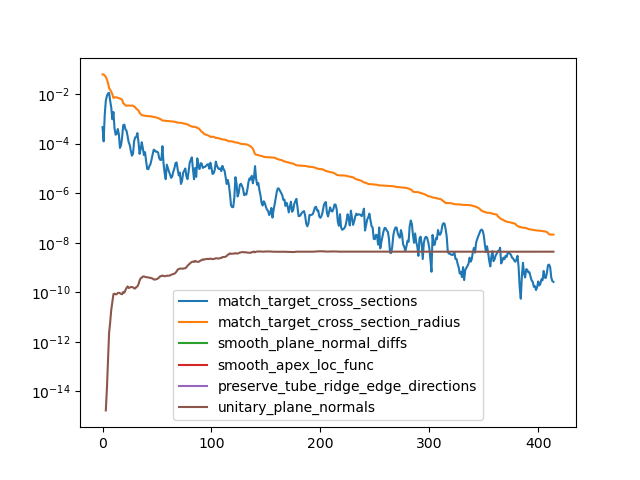

In [24]:
fig, ax = opt_prob.plot_objective_history()

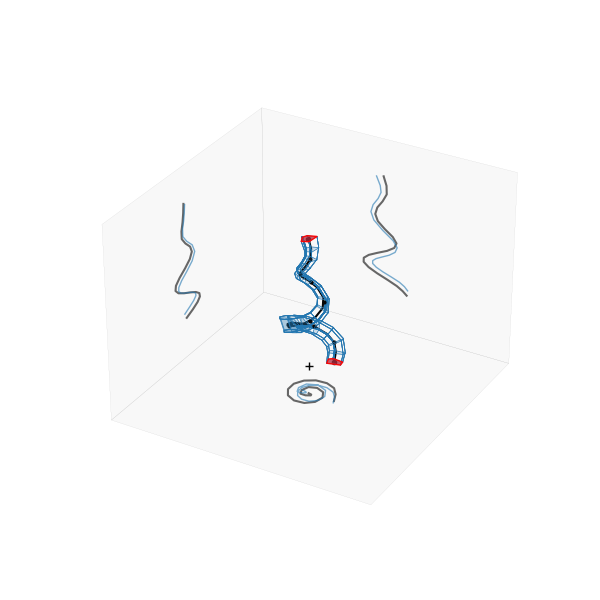

In [25]:
fig, ax = opt_prob.plot_3d()

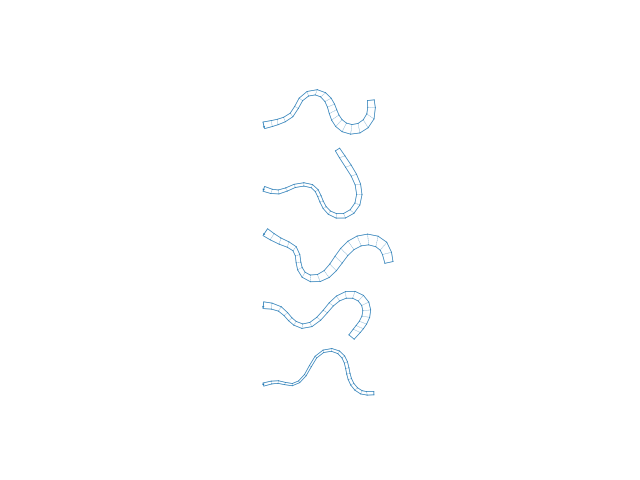

In [26]:
fig, ax = opt_prob.plot_unrolled_strips()

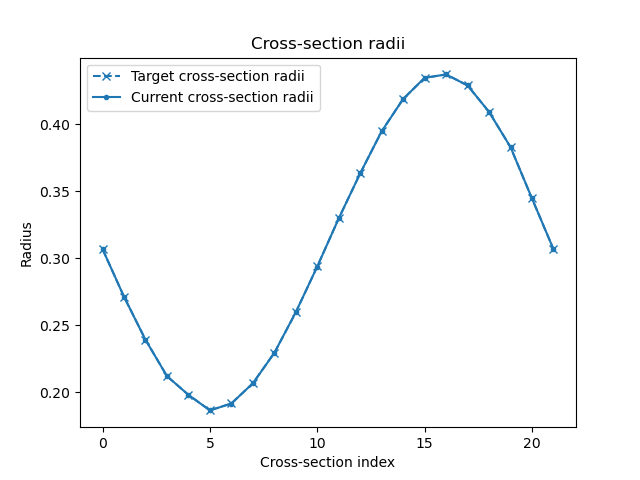

In [27]:
fig, ax = opt_prob.plot_cross_section_radii()

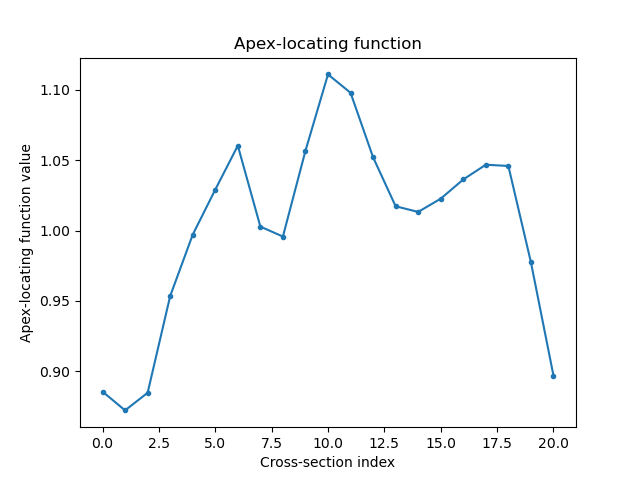

In [28]:
fig, ax = opt_prob.plot_apex_loc_func()